In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
import pyreadr
import os
import time
from scipy.stats import norm
import copy
import warnings
import utils
from importlib import reload
reload(utils)
from utils import *

home = os.getcwd()

## Dataset 

In [2]:
GroupC = pyreadr.read_r(home + '\\Other_data\\GroupC.rda')
GroupC_df = pd.DataFrame(list(GroupC.values())[0])

## Dataset Preprocessing

In [3]:
features = ['t', 't2', 'doy_s', 'doy_c', 'doy_s2', 'doy_c2', 'node_sm', 'clock_hour', 'dow_Rph', 'School_Hol', 
           'x2T_weighted.mean_p_max_point', 'x2Tsm_point', 'SSRD_mean_2_Cap', 'WindSpd100_weighted.mean_cell','EMBEDDED_WIND_CAPACITY',
           'WindSpd10_weighted.mean_cell', 'TP_weighted.mean_cell']
features_to_standardize = ['node_sm','clock_hour','x2T_weighted.mean_p_max_point', 'x2Tsm_point', 'SSRD_mean_2_Cap', 'WindSpd100_weighted.mean_cell','EMBEDDED_WIND_CAPACITY',
                          'WindSpd10_weighted.mean_cell', 'TP_weighted.mean_cell']


def dataset_preprocessing(df, features, features_to_standardize, mean, std):
    df_std = standardize_dataframe(df[features_to_standardize])
    for f in list(set(features) - set(features_to_standardize+['t2'])):
        df_std[f] = df[f]
    df_std['t2'] = df_std['t']**2
    df_std['dow_Rph'] = 1*(df_std['dow_Rph']=='Lun')+2*(df_std['dow_Rph']=='Mar')+\
                            3*(df_std['dow_Rph']=='Mer')+4*(df_std['dow_Rph']=='Jeu')+\
                            5*(df_std['dow_Rph']=='Ven')+6*(df_std['dow_Rph']=='Sam')+\
                            7*(df_std['dow_Rph']=='Dim')+8*(df_std['dow_Rph']=='Hol')
    df_std['School_Hol'] = 1*(df_std['School_Hol']=='N')+2*(df_std['School_Hol']=='School Holiday')+\
                            3*(df_std['School_Hol']=='Christmas Holiday')
    target = (df['node']-mean)/std
    return df_std[features], target

# Training set: up to 31st Dec 2018 (we skip the first 14 days of 2014 because we need the value for the moving average)
train_set = GroupC_df[720:87440]
mean = train_set['node'].mean()
std = train_set['node'].std()
X_train, Y_train = dataset_preprocessing(train_set, features, features_to_standardize, mean, std)

# Test set: from 1st Jan 2019
test_set = GroupC_df[87440:]
X_test, Y_test = dataset_preprocessing(test_set, features, features_to_standardize, mean, std)

# GAM model

In [4]:
from pygam import LinearGAM, s, f, l, te

features = ['t', 't2', 'doy_s', 'doy_c', 'doy_s2', 'doy_c2', 'node_sm', 'clock_hour', 'dow_Rph', 'School_Hol', 
           'x2T_weighted.mean_p_max_point', 'x2Tsm_point', 'SSRD_mean_2_Cap', 'WindSpd100_weighted.mean_cell','EMBEDDED_WIND_CAPACITY',
           'WindSpd10_weighted.mean_cell', 'TP_weighted.mean_cell']

gam_model = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7,n_splines=35,basis='cp') + f(8) + f(9) + 
                     te(7,8,n_splines=30,dtype=['numerical','categorical'],basis='cp')+te(7,9,n_splines=20,dtype=['numerical','categorical'],basis='cp')+
                     s(10,n_splines=35,basis='cp')+s(11,n_splines=35,basis='cp')+s(12,n_splines=5,basis='cp')+ 
                     te(13,14,n_splines=20,basis='cp')+l(15)+s(16,n_splines=5,basis='cp')+te(10,7,n_splines=17)+te(16,7,n_splines=17))

gam_model.fit(np.array(X_train), np.array(Y_train))

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7) + f(8) + f(9) + te(7, 8) + te(7, 9) + s(10) + s(11) + s(12) + te(13, 14) + l(15) + s(16) + te(10, 7) + te(16, 7) + intercept,
   tol=0.0001, verbose=False)

In [5]:
y_GAM_n = gam_model.predict(np.array(X_test))

# Kalman Filter

## Static Kalman Filter

In [6]:
kf_static = Kalman_Filter(gam_model)
kf_static.fit(X_train, Y_train)

In [7]:
y_Kalman_static_n, y_Kalman_static_std_n = kf_static.predict(X_test, Y_test)

## Dynamic Kalman Filter


### Iterative grid search of optimal parameters Q and sigma on the training set

In [9]:
# def f(df, GAM_model):
#     n_terms = len(list(gam_model.terms))
#     features_eval = np.zeros((df.shape[0],n_terms))
#     it = 0
#     for f in range(n_terms):
#         feature_mat = GAM_model._modelmat(np.array(df), term=f)
#         n_coeff_feature = feature_mat.shape[1]
#         features_eval[:, f] = feature_mat@GAM_model.coef_[it:it+n_coeff_feature]
#         it += n_coeff_feature
#     features_eval_std = (features_eval - features_eval.mean(axis=0))/features_eval.std(axis=0)
#     return features_eval_std

In [10]:
# f_X = f(np.array(X_train)[-80000:,:], gam_model)
# res = iterative_grid_search(f_X, np.array(Y_train)[-80000:], 2**np.array([-20.,-15.,-10.,-5.,-3.,-2.,-1.,0]), Q_init=Q/sigma**2)

In [8]:
# with open('DynamicKF_matrices_py/Q_C.npy', 'wb') as f:
#     np.save(f, res['Q'])
#     np.save(f, res['sig'])
#     np.save(f, res['theta'])
#     np.save(f, res['P'])
# Q = res['Q']
# sigma = res['sig']
# theta = res['theta']
# P = res['P']
with open('DynamicKF_matrices_py/Q_C.npy', 'rb') as f:
    Q = np.load(f)
    sigma = np.load(f)
    theta = np.load(f)
    P = np.load(f)


In [9]:
kf_dynamic = Kalman_Filter(gam_model, Q=Q, sigma=sigma, P=P, theta1=theta)
kf_dynamic.fit(X_train, Y_train)

In [10]:
y_Kalman_dynamic_n, y_Kalman_dynamic_std_n = kf_dynamic.predict(X_test, Y_test)

## Results Comparison of Mean Prediction on test set

Text(0.5, 1.0, 'Test set - Mean prediction')

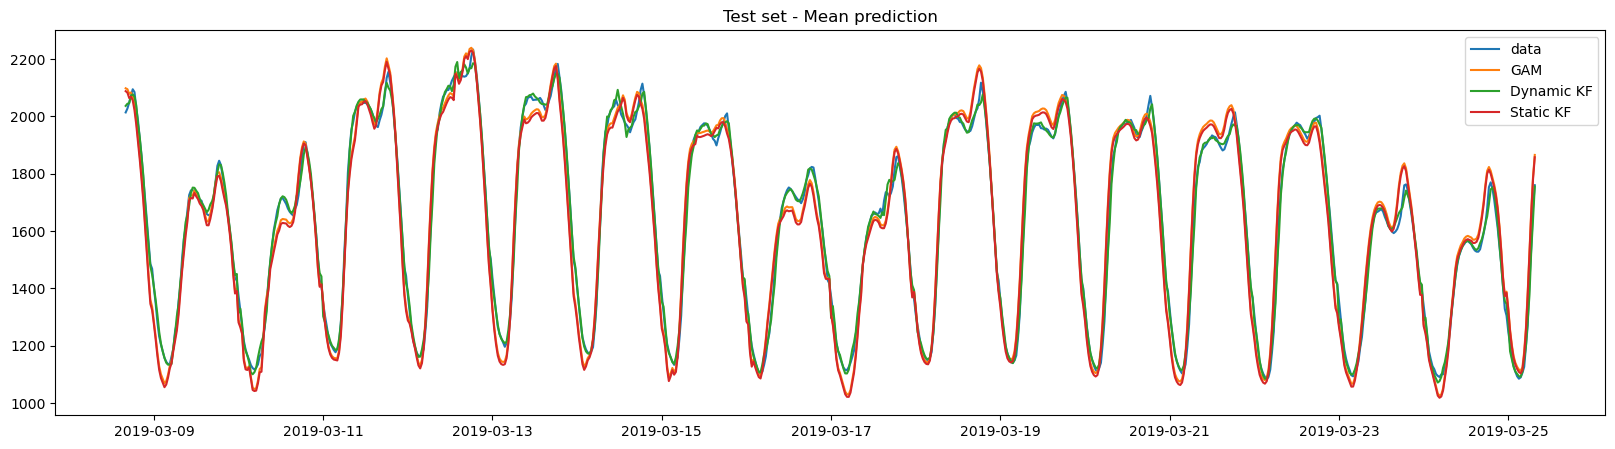

In [34]:
l=3200
j=4000

y_GAM = train_set['node'].mean() + y_GAM_n*train_set['node'].std()
y_Kalman_static = train_set['node'].mean() + y_Kalman_static_n*train_set['node'].std()
y_Kalman_dynamic = train_set['node'].mean() + y_Kalman_dynamic_n*train_set['node'].std()

fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][l:j], test_set['node'][l:j], label='data')
plt.plot(test_set['targetTime'][l:j], y_GAM[l:j], label='GAM')
plt.plot(test_set['targetTime'][l:j], y_Kalman_dynamic[l:j], label='Dynamic KF')
plt.plot(test_set['targetTime'][l:j], y_Kalman_static[l:j], label='Static KF')
plt.legend()
plt.title('Test set - Mean prediction')

Text(0.5, 1.0, 'Test set - Mean prediction')

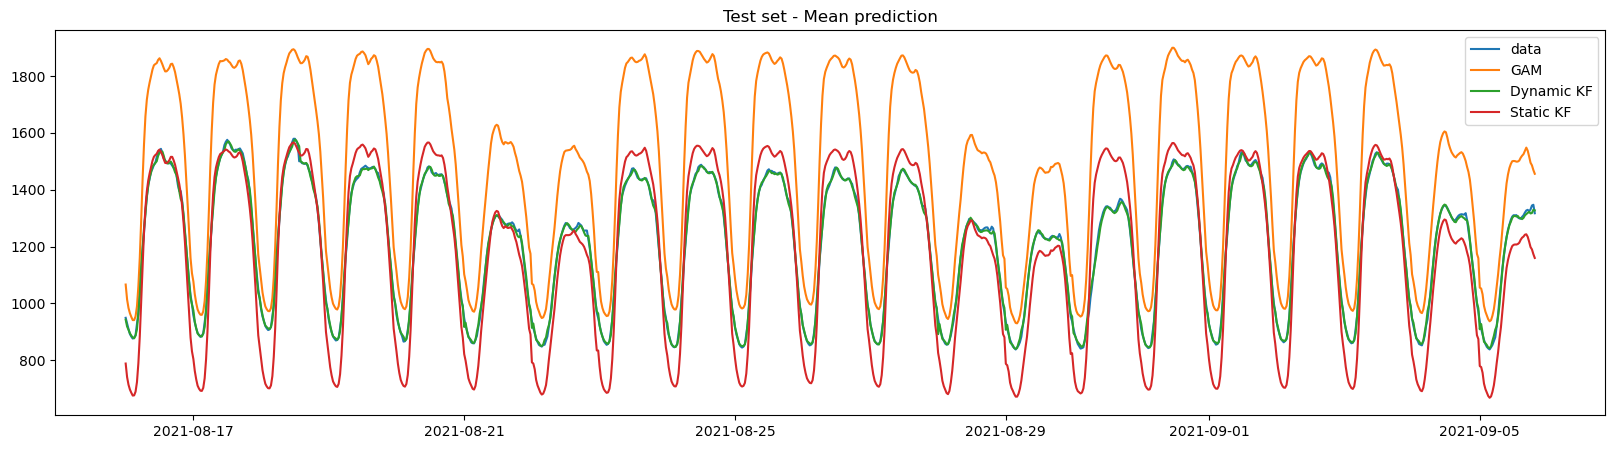

In [18]:
l=46000
j=47000

y_GAM = train_set['node'].mean() + y_GAM_n*train_set['node'].std()
y_Kalman_static = train_set['node'].mean() + y_Kalman_static_n*train_set['node'].std()
y_Kalman_dynamic = train_set['node'].mean() + y_Kalman_dynamic_n*train_set['node'].std()

fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][l:j], test_set['node'][l:j], label='data')
plt.plot(test_set['targetTime'][l:j], y_GAM[l:j], label='GAM')
plt.plot(test_set['targetTime'][l:j], y_Kalman_dynamic[l:j], label='Dynamic KF')
plt.plot(test_set['targetTime'][l:j], y_Kalman_static[l:j], label='Static KF')
plt.legend()
plt.title('Test set - Mean prediction')

In [19]:
print("RMSE GAM: ", RMSE(test_set['node'], y_GAM))
print("RMSE Static Kalman filter: ", RMSE(test_set['node'], y_Kalman_static))
print("RMSE Dynamic Kalman filter: ", RMSE(test_set['node'], y_Kalman_dynamic))

print("\nMAE GAM: ", MAE(test_set['node'], y_GAM))
print("MAE Static Kalman filter: ", MAE(test_set['node'], y_Kalman_static))
print("MAE Dynamic Kalman filter: ", MAE(test_set['node'], y_Kalman_dynamic))

print("\nMAPE GAM: ", MAPE(test_set['node'], y_GAM))
print("MAPE Static Kalman filter: ", MAPE(test_set['node'], y_Kalman_static))
print("MAPE Dynamic Kalman filter: ", MAPE(test_set['node'], y_Kalman_dynamic))

RMSE GAM:  228.40357936047604
RMSE Static Kalman filter:  113.10983536385983
RMSE Dynamic Kalman filter:  15.430144754458853

MAE GAM:  191.77737877803787
MAE Static Kalman filter:  85.210326145707
MAE Dynamic Kalman filter:  11.086103444225191

MAPE GAM:  0.13880271829834517
MAPE Static Kalman filter:  0.06504504682470053
MAPE Dynamic Kalman filter:  0.008011973760474744


# Probabilistic Forecast


## GAM mean + GAM Normal Quantiles

In [15]:
q_vec = np.array([0.001,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,0.98,0.99,0.999])

## Test set

In [36]:
q_U = 0.975
q_L = 0.025

y_GAM_train = train_set['node'].mean() + gam_model.predict(np.array(X_train))*train_set['node'].std() #mean prediction on training set
y_GAM_train_std = (train_set['node']-y_GAM_train).std() #standard deviation of the residuals on the training set
y_qU_GAM = y_GAM + norm.ppf(q_U)*y_GAM_train_std
y_qL_GAM = y_GAM + norm.ppf(q_L)*y_GAM_train_std

In [19]:
print("Pinball score upper quantile train set: ", pinball_score_alpha(y_qU_GAM,test_set['node'],q_U))
print("Pinball score lower quantile train set: ", pinball_score_alpha(y_qL_GAM,test_set['node'],q_L))

Pinball score upper quantile train set:  8.956534003237527
Pinball score lower quantile train set:  62.20660484325375


Text(0.5, 1.0, 'Test set - GAM quantiles')

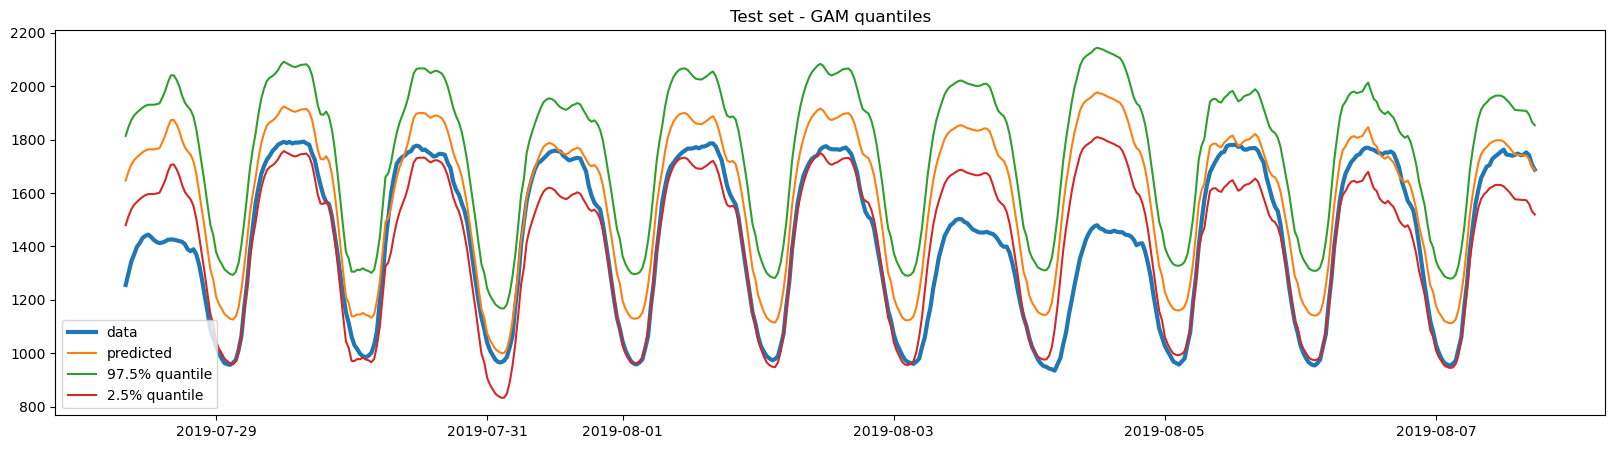

In [20]:
j=10000
k=10500

# train set
fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_GAM[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_qU_GAM[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_qL_GAM[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - GAM quantiles')

## Pinball score and RPS - Test set

In [37]:
estimated_quantile_1 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_1[:,i] = y_GAM + norm.ppf(q_vec[i])*y_GAM_train_std
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_1, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_1, test_set['node'], q_vec))

Pinball loss test set:  55.08232701497906
RPS on test set:  8.008599586164992


Text(0.5, 1.0, 'Test set - GAM mean + GAM Normal Quantiles')

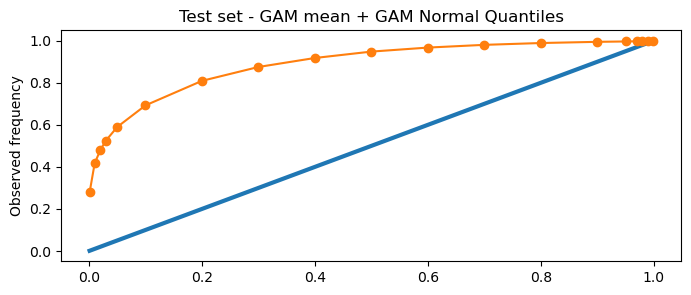

In [22]:
y_klm_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_pred = y_GAM + norm.ppf(q)*y_GAM_train_std
        obs_freq[j] = np.shape(y_pred[y_pred > np.array(test_set['node'])])[0]/len(test_set['node'])


fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - GAM mean + GAM Normal Quantiles')

# Kalman Filter Quantiles

## Static Kalman Filter mean + Normal KF Quantile

Test set

In [39]:
q_U = 0.975
q_L = 0.025

y_Kalman_static_std = y_Kalman_static_std_n*(train_set['node']).std()
y_qU_StaticKF = y_Kalman_static + norm.ppf(q_U)*y_Kalman_static_std
y_qL_StaticKF = y_Kalman_static + norm.ppf(q_L)*y_Kalman_static_std

In [24]:
print("Pinball score upper quantile test set: ", pinball_score_alpha(y_qU_StaticKF,test_set['node'],q_U))
print("Pinball score lower quantile test set: ", pinball_score_alpha(y_qL_StaticKF,test_set['node'],q_L))

Pinball score upper quantile test set:  18.597017219969015
Pinball score lower quantile test set:  18.048385353598736


Text(0.5, 1.0, 'Test set - Static Kalman Filter quantiles')

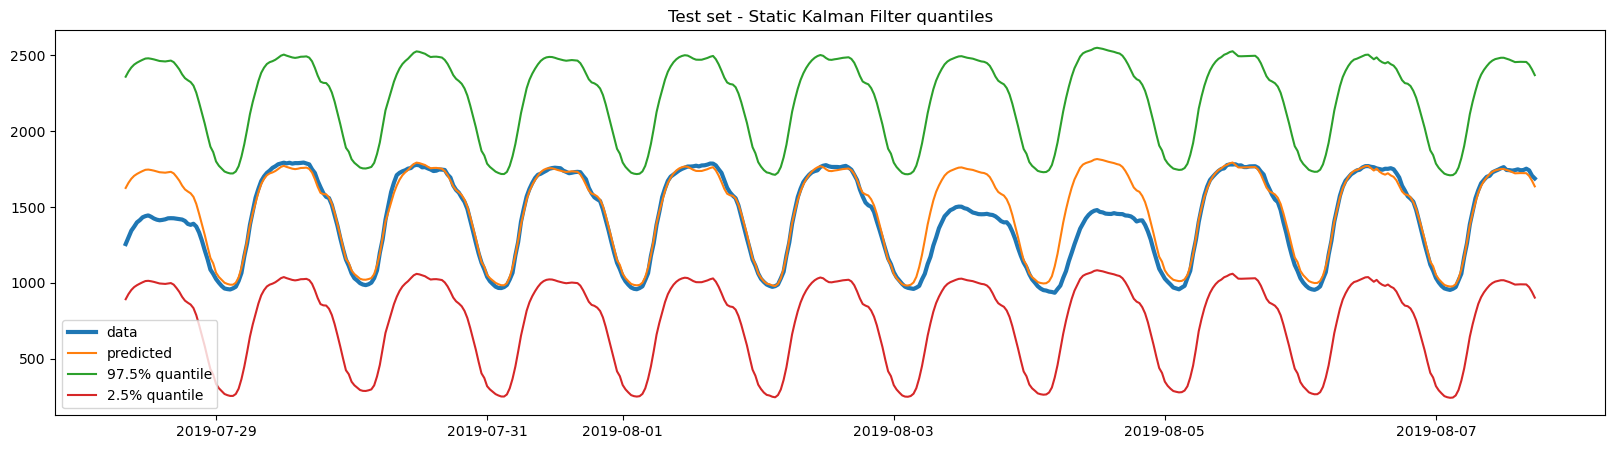

In [25]:
j=10000
k=10500

# train set
fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_Kalman_static[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_qU_StaticKF[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_qL_StaticKF[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - Static Kalman Filter quantiles')

## Pinball score and RPS - Test set

In [40]:
estimated_quantile_2 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_2[:,i] = y_Kalman_static + norm.ppf(q_vec[i])*y_Kalman_static_std
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_2, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_2, test_set['node'], q_vec))

Pinball loss test set:  33.85133879317011
RPS on test set:  5.239654176688247


Text(0.5, 1.0, 'Test set - Static KF mean + Normal KF Quantile')

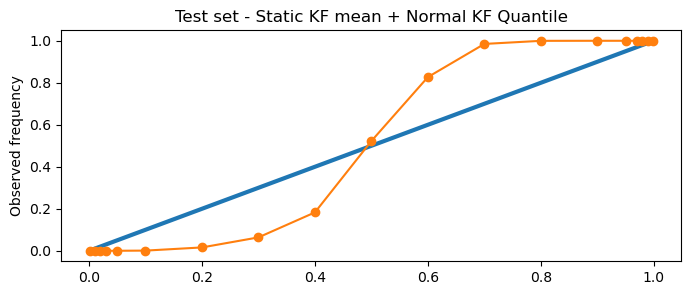

In [27]:
y_klm_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_pred = y_Kalman_static + norm.ppf(q)*y_Kalman_static_std
        obs_freq[j] = np.shape(y_pred[y_pred > np.array(test_set['node'])])[0]/len(test_set['node'])


fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - Static KF mean + Normal KF Quantile')

## Dynamic Kalman Filter Mean + Normal KF Quantile

Test set

In [43]:
q_U = 0.975
q_L = 0.025

y_Kalman_dynamic_std = y_Kalman_dynamic_std_n*(train_set['node']).std()
y_qU_DynamicKF = y_Kalman_dynamic + norm.ppf(q_U)*y_Kalman_dynamic_std
y_qL_DynamicKF = y_Kalman_dynamic + norm.ppf(q_L)*y_Kalman_dynamic_std

In [29]:
print("Pinball score upper quantile test set: ", pinball_score_alpha(y_qU_DynamicKF,test_set['node'],q_U))
print("Pinball score lower quantile test set: ", pinball_score_alpha(y_qL_DynamicKF,test_set['node'],q_L))

Pinball score upper quantile test set:  1.3406583268227312
Pinball score lower quantile test set:  1.261353231211261


Text(0.5, 1.0, 'Test set - Dynamic Kalman Filter Normal quantiles')

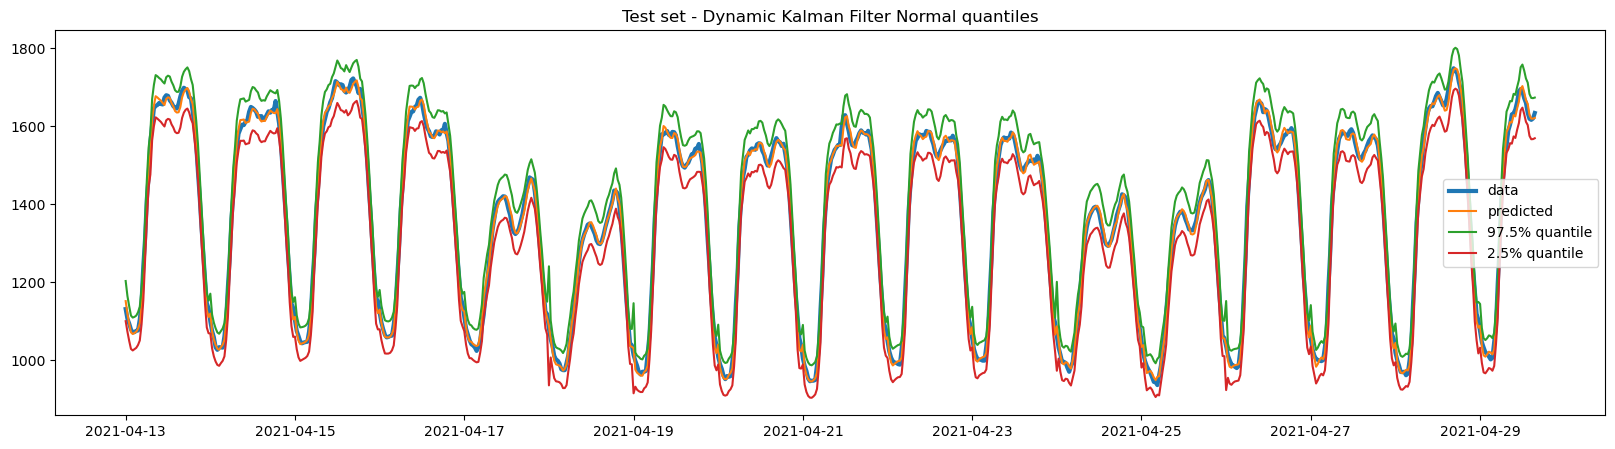

In [30]:
j=40000
k=40800

# train set
fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_Kalman_dynamic[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_qU_DynamicKF[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_qL_DynamicKF[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - Dynamic Kalman Filter Normal quantiles')

## Pinball loss and RPS

In [44]:
estimated_quantile_3 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_3[:,i] = y_Kalman_dynamic + norm.ppf(q_vec[i])*y_Kalman_dynamic_std
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_3, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_3, test_set['node'], q_vec))

Pinball loss test set:  2.932062155132202
RPS on test set:  0.47695611528985277


Text(0.5, 1.0, 'Test set - Dynamic KF + Normal Quantile')

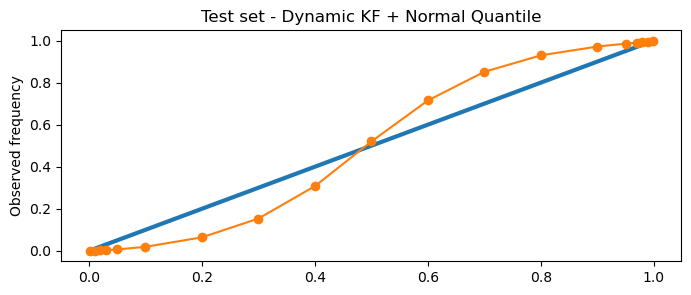

In [32]:
y_klm_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_pred = y_Kalman_dynamic + norm.ppf(q)*y_Kalman_dynamic_std
        obs_freq[j] = np.shape(y_pred[y_pred > np.array(test_set['node'])])[0]/len(test_set['node'])

fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - Dynamic KF + Normal Quantile')

# Quantile Regression

# Static Kalman Filter + Quantile Regression

In [46]:
y_Kalman_static_train_n, _ = kf_static.predict(np.array(X_train), np.array(Y_train))
y_Kalman_static_train = train_set['node'].mean() + y_Kalman_static_train_n*train_set['node'].std()

qr_kf_static = Quantile_Regression(train_set, train_set['node'], y_Kalman_static_train)

## Test set

In [47]:
q_U = 0.975
q_L = 0.025
y_qU = qr_kf_static.predict(q_U, test_set, y_Kalman_static)
y_qL = qr_kf_static.predict(q_L, test_set, y_Kalman_static)

In [35]:
print("Pinball score upper quantile test set: ", pinball_score_alpha(y_qU,test_set['node'],q_U))
print("Pinball score lower quantile test set: ", pinball_score_alpha(y_qL,test_set['node'],q_L))

Pinball score upper quantile test set:  8.831571898522032
Pinball score lower quantile test set:  8.942159088710863


Text(0.5, 1.0, 'Test set - Static KF + Quantile Regression')

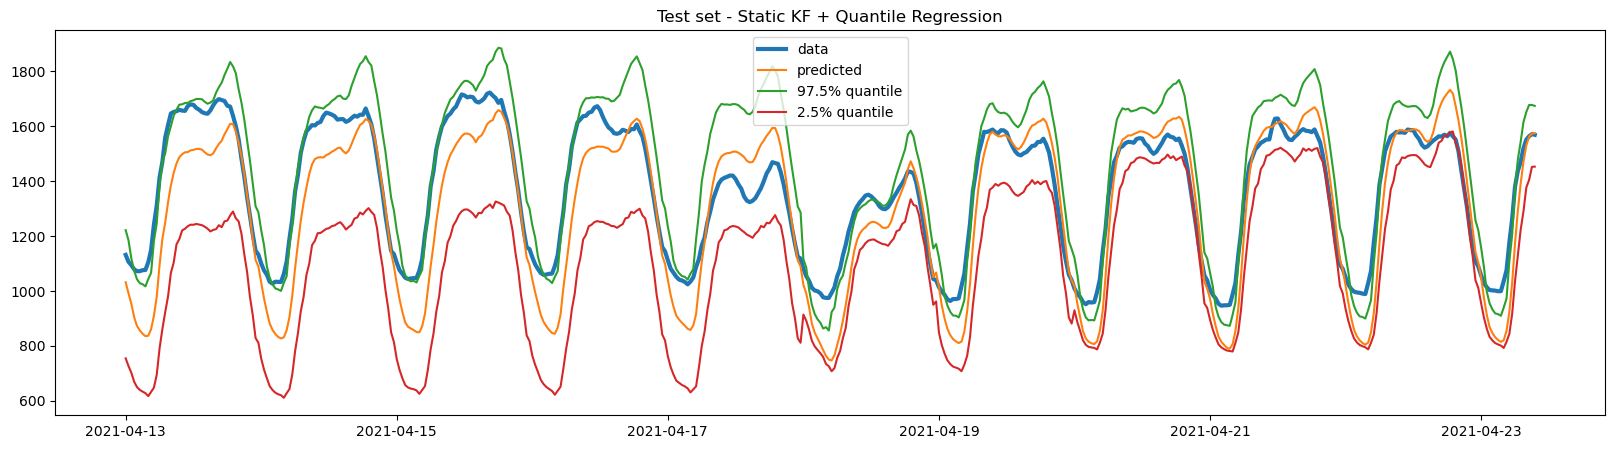

In [36]:
j=40000
k=40500

fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_Kalman_static[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_qU[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_qL[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - Static KF + Quantile Regression')

## Pinball score and RPS - Test set

In [48]:
estimated_quantile_5 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_5[:,i] = qr_kf_static.predict(q_vec[i], test_set, y_Kalman_static)
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_5, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_5, test_set['node'], q_vec))

Pinball loss test set:  20.236921035099048
RPS on test set:  3.2867645843376696


Text(0.5, 1.0, 'Test set - Static KF + Quantile Regression')

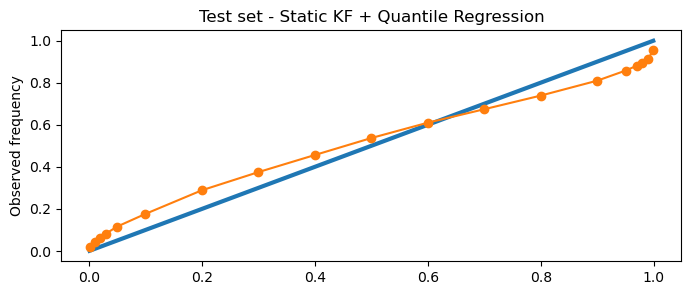

In [38]:
y_klm_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_pred = qr_kf_static.predict(q_vec[j], test_set, y_Kalman_static)
        obs_freq[j] = np.shape(y_pred[y_pred > np.array(test_set['node'])])[0]/len(test_set['node'])

fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - Static KF + Quantile Regression')

# Dynamic Kalman Filter + Quantile Regression

In [11]:
y_Kalman_dynamic_train_n, _ = kf_dynamic.predict(np.array(X_train), np.array(Y_train))
y_Kalman_dynamic_train = train_set['node'].mean() + y_Kalman_dynamic_train_n*train_set['node'].std()

qr_kf_dynamic = Quantile_Regression(train_set, train_set['node'], y_Kalman_dynamic_train)

## Test set

In [25]:
q_U = 0.975
q_L = 0.025
y_qU = qr_kf_dynamic.predict(q_U, test_set, y_Kalman_dynamic)
y_qL = qr_kf_dynamic.predict(q_L, test_set, y_Kalman_dynamic)

In [41]:
print("Pinball score upper quantile test set: ", pinball_score_alpha(y_qU,test_set['node'],q_U))
print("Pinball score lower quantile test set: ", pinball_score_alpha(y_qL,test_set['node'],q_L))

Pinball score upper quantile test set:  1.013446309546587
Pinball score lower quantile test set:  0.8876333390977342


Text(0.5, 1.0, 'Test set - Dynamic KF + Quantile Regression')

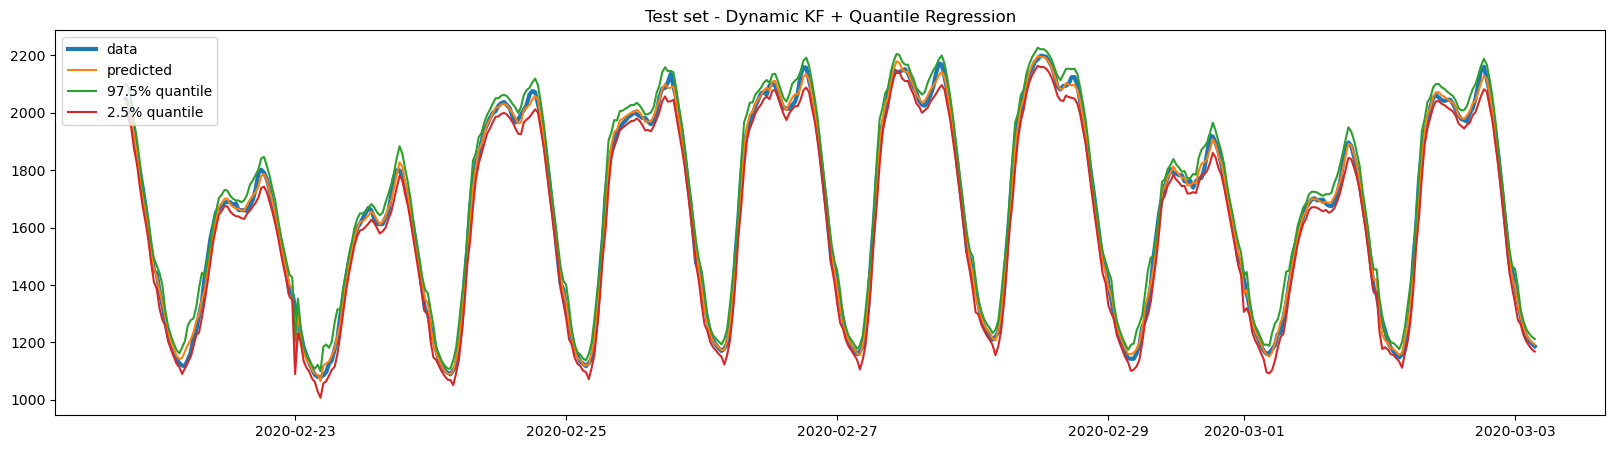

In [42]:
j=20000
k=20500

# train set
fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_Kalman_dynamic[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_qU[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_qL[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - Dynamic KF + Quantile Regression')

## Pinball score and RPS - Test set

In [20]:
estimated_quantile_6 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_6[:,i] = qr_kf_dynamic.predict(q_vec[i], test_set, y_Kalman_dynamic)
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_6, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_6, test_set['node'], q_vec))

Pinball loss test set:  2.4930498016921416
RPS on test set:  0.41793866053663103


Text(0.5, 1.0, 'Test set - Dynamic KF + Quantile Regression')

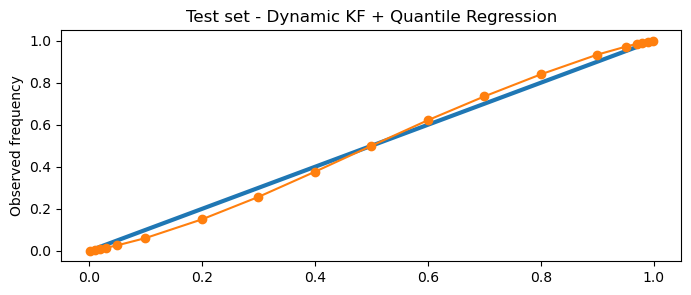

In [21]:
y_klm_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_pred = qr_kf_dynamic.predict(q, test_set, y_Kalman_dynamic)
        obs_freq[j] = np.shape(y_pred[y_pred > np.array(test_set['node'])])[0]/len(test_set['node'])

fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - Dynamic KF + Quantile Regression')

# Online Quantile Regression

## Dynamic Kalman Filter + Online Quantile Regression

In [22]:
ogd = Online_Gradient_Descent(train_set, train_set['node'], y_Kalman_dynamic_train)

### Test Set

In [23]:
alpha = 0.1
y_upper_odg = ogd.predict(0.975,test_set,np.array(test_set['node']),y_Kalman_dynamic, alpha)
y_lower_odg = ogd.predict(0.025,test_set,np.array(test_set['node']),y_Kalman_dynamic, alpha)

In [26]:
print("Pinball score upper quantile test set: ", pinball_score_alpha(y_upper_odg,test_set['node'],q_U))
print("Pinball score lower quantile test set: ", pinball_score_alpha(y_lower_odg,test_set['node'],q_L))

Pinball score upper quantile test set:  0.9477953454669349
Pinball score lower quantile test set:  0.8004317695162668


Text(0.5, 1.0, 'Test set - Dynamic KF + Online Quantile Regression')

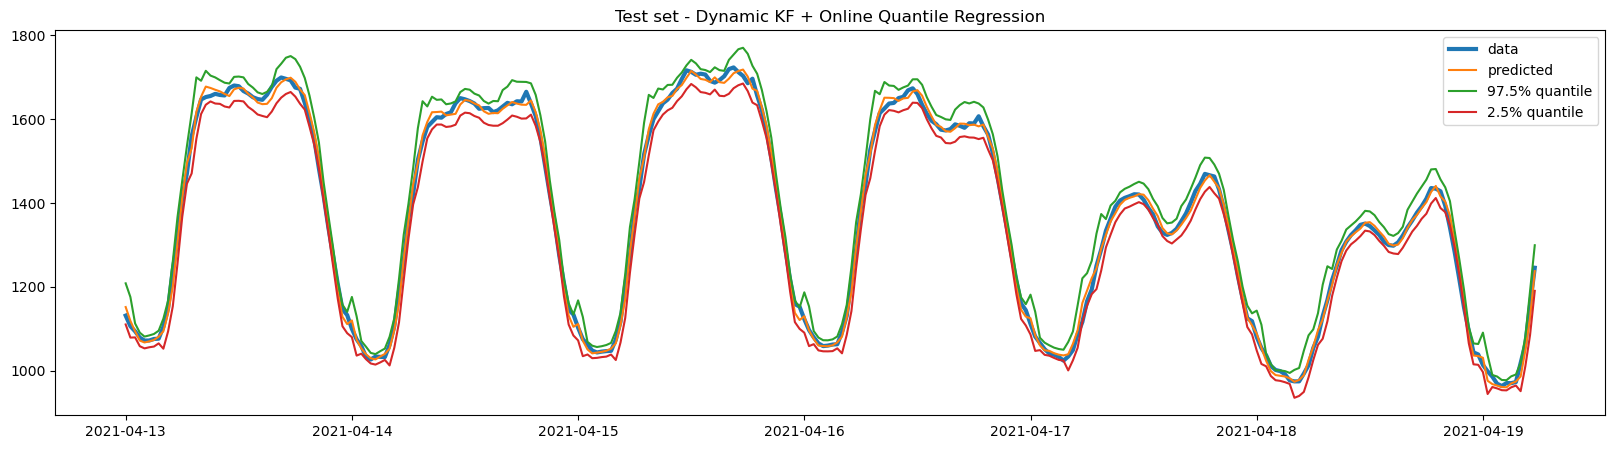

In [27]:
j=40000
k=40300

fig, axs = plt.subplots(1,1,figsize=(20,5))
plt.plot(test_set['targetTime'][j:k], test_set['node'][j:k], label='data', linewidth=3)
plt.plot(test_set['targetTime'][j:k], y_Kalman_dynamic[j:k], label='predicted')
plt.plot(test_set['targetTime'][j:k], y_upper_odg[j:k], label='97.5% quantile')
plt.plot(test_set['targetTime'][j:k], y_lower_odg[j:k], label='2.5% quantile')
plt.legend()
plt.title('Test set - Dynamic KF + Online Quantile Regression')

## Step size choice

In [28]:
alpha_vec = np.logspace(-10,0.1,20, base=2)
pinball_mat = np.ones((q_vec.shape[0],alpha_vec.shape[0]))

for i, alpha in enumerate(alpha_vec):
    for j, q in enumerate(q_vec):
        y_ogd = ogd.predict(q,test_set,np.array(test_set['node']),y_Kalman_dynamic,alpha=alpha)
        pinball_mat[j,i] = pinball_score_alpha(y_ogd,test_set['node'],q)

In [29]:
idx = np.argmin(pinball_mat, axis=1)
alpha_opt = alpha_vec[idx]

y_ogd_mat = np.zeros((len(test_set['node']),q_vec.shape[0]))
obs_freq = np.zeros(q_vec.shape[0])

for j, q in enumerate(q_vec):
        y_ogd = ogd.predict(q,test_set,np.array(test_set['node']),y_Kalman_dynamic,alpha=alpha_opt[j])
        obs_freq[j] = np.shape(y_ogd[y_ogd > np.array(test_set['node'])])[0]/len(test_set['node'])

In [30]:
estimated_quantile_7 = np.zeros((len(test_set['node']), q_vec.shape[0]))

for i in range(q_vec.shape[0]):
    estimated_quantile_7[:,i] = ogd.predict(q_vec[i],test_set,np.array(test_set['node']),y_Kalman_dynamic,alpha=alpha_opt[i])
    
print("Pinball loss test set: ", pinball_score(estimated_quantile_7, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_7, test_set['node'], q_vec))

Pinball loss test set:  2.2579351527170655
RPS on test set:  0.3799641713447823


Text(0.5, 1.0, 'Test set - Dynamic KF + Online Quantile Regression')

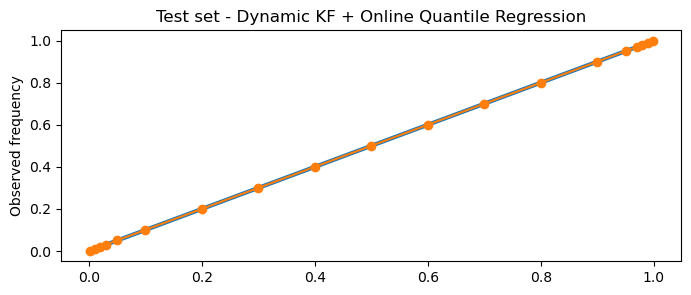

In [31]:
fig, axs = plt.subplots(1,1,figsize=(8,3))
plt.plot(q_vec, q_vec, linewidth=3)
plt.plot(q_vec, obs_freq, '-o')
plt.ylabel("Observed frequency")
plt.title('Test set - Dynamic KF + Online Quantile Regression')

## Results Comparison

In [49]:
print("Pinball Loss GAM mean + Normal Residual Distribution: ", pinball_score(estimated_quantile_1, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_1, test_set['node'], q_vec))

print("\nPinball loss Static KF mean + Normal Residual Distribution: ", pinball_score(estimated_quantile_2, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_2, test_set['node'], q_vec))

print("\nPinball loss Dynamic KF mean + Normal Residual Distribution: ", pinball_score(estimated_quantile_3, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_3, test_set['node'], q_vec))

print("\nPinball loss Static KF mean + Quantile regression: ", pinball_score(estimated_quantile_5, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_5, test_set['node'], q_vec))

print("\nPinball loss Dynamic KF mean + Quantile regression: ", pinball_score(estimated_quantile_6, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_6, test_set['node'], q_vec))

print("\nPinball loss Dynamic KF mean + Online Quantile regression: ", pinball_score(estimated_quantile_7, test_set['node'], q_vec))
print("RPS on test set: ", RPS(estimated_quantile_7, test_set['node'], q_vec))

Pinball Loss GAM mean + Normal Residual Distribution:  55.08232701497906
RPS on test set:  8.008599586164992

Pinball loss Static KF mean + Normal Residual Distribution:  33.85133879317011
RPS on test set:  5.239654176688247

Pinball loss Dynamic KF mean + Normal Residual Distribution:  2.932062155132202
RPS on test set:  0.47695611528985277

Pinball loss Static KF mean + Quantile regression:  20.236921035099048
RPS on test set:  3.2867645843376696

Pinball loss Dynamic KF mean + Quantile regression:  2.4930498016921416
RPS on test set:  0.41793866053663103

Pinball loss Dynamic KF mean + Online Quantile regression:  2.2579351527170655
RPS on test set:  0.3799641713447823
